<a href="https://colab.research.google.com/github/MH-Insights/ecommerce-funnel-conversion/blob/main/Ecommerce_FunnelConversionAnalysis_CartAbandonmentFocus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Executive Summary:
# Total users analyzed: 90,400
# Overall funnel completion rate: 0.86%
# Biggest drop-off: Payment → Confirmation
# Top-performing segment: Mobile Females (1.11% CVR)
# Key opportunity: Most users reach the payment page but don't convert - improving this single step could unlock significant revenue

In [2]:
# Upload Kaggle api key file
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"michelletho","key":"2ffd6e9c4e8b46126e97238d6183e7cd"}'}

In [3]:
# Set up Kaggle cli with api key
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle cli
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d aerodinamicc/ecommerce-website-funnel-analysis

# Unzip dataset
import zipfile
with zipfile.ZipFile("ecommerce-website-funnel-analysis.zip", "r") as zip_ref:
    zip_ref.extractall("ecommerce_data")

Dataset URL: https://www.kaggle.com/datasets/aerodinamicc/ecommerce-website-funnel-analysis
License(s): unknown


In [4]:
# Load data

# Check contents of extracted folder
import os
os.listdir("ecommerce_data")

# Load raw data
import pandas as pd
users = pd.read_csv("ecommerce_data/user_table.csv")
home = pd.read_csv("ecommerce_data/home_page_table.csv")
search = pd.read_csv("ecommerce_data/search_page_table.csv")
payment = pd.read_csv("ecommerce_data/payment_page_table.csv")
confirmation = pd.read_csv("ecommerce_data/payment_confirmation_table.csv")

In [5]:
# Build funnel_df
funnel_df = users[['user_id', 'device', 'sex']].copy()

# Add funnel stage flags
funnel_df['visited_home'] = funnel_df['user_id'].isin(home['user_id']).astype(int)
funnel_df['visited_search'] = funnel_df['user_id'].isin(search['user_id']).astype(int)
funnel_df['visited_payment'] = funnel_df['user_id'].isin(payment['user_id']).astype(int)
funnel_df['confirmed_payment'] = funnel_df['user_id'].isin(confirmation['user_id']).astype(int)

# Check
display(funnel_df.sample(5))
print(funnel_df['user_id'].nunique(), funnel_df.shape[0])

,user_id,device,sex,visited_home,visited_search,visited_payment,confirmed_payment
19287,906047,Mobile,Female,1,0,0,0
16188,572123,Desktop,Male,1,0,0,0
86050,451783,Desktop,Male,1,0,0,0
88815,573029,Desktop,Female,1,0,0,0
14809,43433,Desktop,Female,1,1,1,0


90400 90400


Funnel Conversion Rates:
1. Home → Search: 50.00%
2. Search → Payment: 13.34%
3. Payment → Confirmation: 7.50%
Overall Conversion (User → Confirmed Payment): 0.50%


,Step,Users,Drop-off From Prev (%)
0,Visited Home,90400,NaN
1,Visited Search,45200,50.000000
2,Visited Payment,6030,86.659292
3,Confirmed Payment,452,92.504146


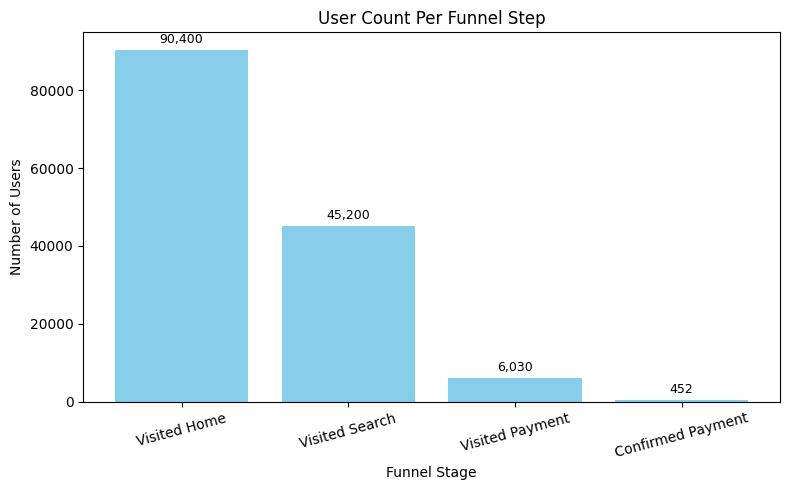

In [6]:
# 1. Where are users dropping off in the funnel?
# → What percentage of users move from one funnel step to the next?
# → Calculate conversion rates at each stage (homepage → search → payment → confirmation) to identify where users disengage
# Product pov: The biggest opportunity is at X stage so that's where we'll gain the most from investing UX or incentives

# Total users at each step
total_users = funnel_df.shape[0]  # or len(df)
home_visits = funnel_df['visited_home'].sum()
search_visits = funnel_df['visited_search'].sum()
payment_visits = funnel_df['visited_payment'].sum()
payment_confirmations = funnel_df['confirmed_payment'].sum()

# Conversion rates between steps
conversion_home_to_search = search_visits / home_visits if home_visits else 0
conversion_search_to_payment = payment_visits / search_visits if search_visits else 0
conversion_payment_to_confirmation = payment_confirmations / payment_visits if payment_visits else 0
overall_conversion = payment_confirmations / total_users if total_users else 0

# Print results
print("Funnel Conversion Rates:")
print(f"1. Home → Search: {conversion_home_to_search:.2%}")
print(f"2. Search → Payment: {conversion_search_to_payment:.2%}")
print(f"3. Payment → Confirmation: {conversion_payment_to_confirmation:.2%}")
print(f"Overall Conversion (User → Confirmed Payment): {overall_conversion:.2%}")

# Table: absolute vs % conversion rates
import pandas as pd

funnel_summary = pd.DataFrame({
    "Step": [
        "Visited Home",
        "Visited Search",
        "Visited Payment",
        "Confirmed Payment"
    ],
    "Users": [
        home_visits,
        search_visits,
        payment_visits,
        payment_confirmations
    ],
    "Drop-off From Prev (%)": [
        None,  # All users in this dataset hit the homepage
        100 * (1 - conversion_home_to_search),
        100 * (1 - conversion_search_to_payment),
        100 * (1 - conversion_payment_to_confirmation)
    ]
})

display(funnel_summary)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(funnel_summary["Step"], funnel_summary["Users"], color='skyblue')
for i, val in enumerate(funnel_summary["Users"]):
    plt.text(i, val + 1000, f'{val:,}', ha='center', va='bottom', fontsize=9)
plt.title("User Count Per Funnel Step")
plt.xlabel("Funnel Stage")
plt.ylabel("Number of Users")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# The largest user drop off occurs after the search step, with only ~13% of users continuing to the payment page and ~7.5% confirming payment
# → Let's prioritize understanding friction at the search and payment pages. A/B tests, improved product descriptions, or incentive nudges here could recover substantial revenue

# Only 0.5% of users complete the full funnel
# → Significant opportunity to optimize mid-to-lower funnel experience
# → Increasing search to payment conversion by even a few % can meaningfully lift revenue

# ~87% drop off from search to payment stages
# → Search to payment is our most fragile link
# → Explore friction here. Why aren't users adding to cart and proceeding to payment? Irrelevant searches? Pricing concerns?

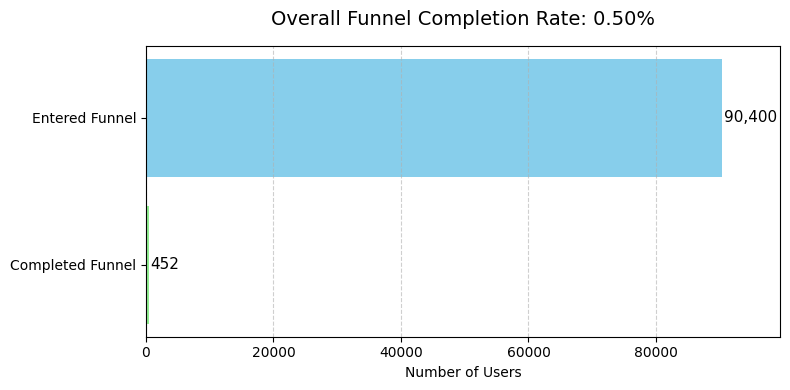

In [7]:
# 2. What's the overall funnel completion rate?
# → Out of all users who entered, how many completed the journey?
# → Gain a sense of the funnel's overall efficiency
# Product pov: The % who complete the funnel sets our benchmark for next quarter's goals

import matplotlib.pyplot as plt

# Data
labels = ['Entered Funnel', 'Completed Funnel']
values = [total_users, payment_confirmations]
conversion_rate = overall_conversion * 100  # percent

# Reverse for top-down
labels = labels[::-1]
values = values[::-1]

# Visualization
plt.figure(figsize=(8, 4))
bars = plt.barh(labels, values, color=['lightgreen', 'skyblue'])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 300, bar.get_y() + bar.get_height() / 2,
             f'{int(width):,}', va='center', fontsize=11)
plt.title(f'Overall Funnel Completion Rate: {conversion_rate:.2f}%', fontsize=14, pad=15)
plt.xlabel('Number of Users')
plt.xlim(0, total_users * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Funnel completion rate summary

# Total funnel entrants: 90,400 users
# Total completions (confirmed payment): 452 users
# Overall funnel completion rate: 0.50%

# Only 0.5% of users complete the entire journey → this metric is our north star for funnel optimization

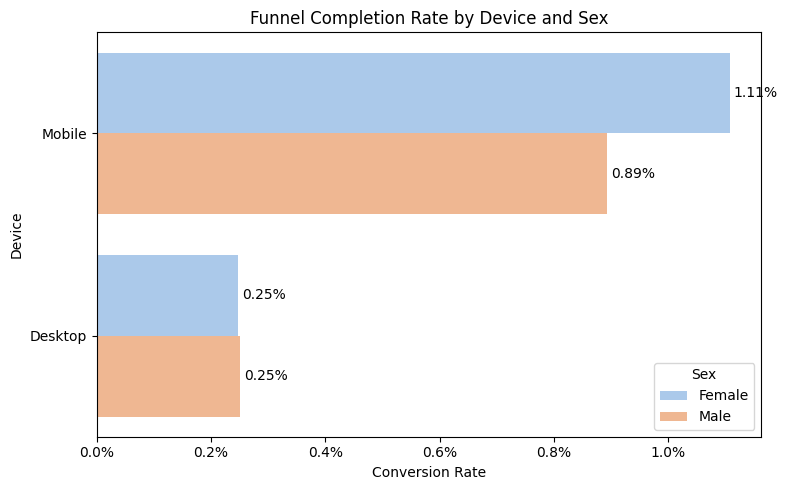

In [8]:
# 3. Which users are more likely to convert?
# → How does conversion vary by device, gender, or other user traits?
# → Segment the funnel to identify behavior patterns
# Product pov: If conversion from a certain segment is low then investigate friction points in that context

# Group and calculate funnel completion rates
segment_df = (
    funnel_df
    .groupby(['device', 'sex'])
    .agg(
        total_users=('user_id', 'count'),
        confirmed_payments=('confirmed_payment', 'sum')
    )
    .reset_index()
)

# Compute conversion rate in %
segment_df['conversion_rate'] = (
    segment_df['confirmed_payments'] / segment_df['total_users'] * 100
)

# Sort by conversion rate (optional, for clarity)
segment_df = segment_df.sort_values(by='conversion_rate', ascending=False)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=segment_df,
    x='conversion_rate',
    y='device',
    hue='sex',
    palette='pastel'
)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

# Annotate bars with conversion rate labels
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{w.get_width():.2f}%" for w in container],
        label_type='edge',
        padding=3,
        fontsize=10,
        color='black'
    )

plt.title('Funnel Completion Rate by Device and Sex')
plt.xlabel('Conversion Rate')
plt.ylabel('Device')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()


# The female mobile conversion rate exceeds outperforms across genders and devices
# → Mobile UX supports conversion, especially for female users
# → What's working well - speed, CTA placement, messaging, product fit, UI layout, offer?
# → Apply learnings across other segments

# Male mobile users convert slightly lower than females but still better than any desktop users
# The male mobile conversion rate is near 0.9%, robust compared to desktop
# → Mobile is working better for male and female users
# → Investigate what differentiates mobile's UX, ensure consistency, scale

# Desktop users are not converting
# → Slight gender gap favoring female desktop users - is the gap meaningful?
# → Audit experience: Are CTAs buried? Is content misaligned?
# → Consider: session duration, user intent, scroll depth, exit pages, etc

Cart Abandonment Rate: 92.50%
Users at Payment Page: 6030
Confirmed Payments: 452
Users Abandoned After Payment Page: 5578


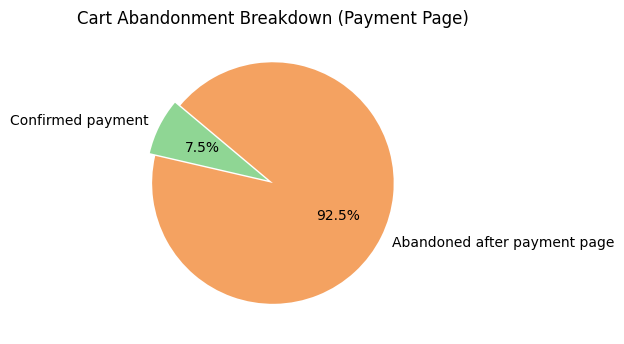

In [9]:
# 4. Where is cart abandonment happening?
# → How many users reach the payment page but don't confirm payment?
# → This pinpoints the cart abandonment rate, a key ecom kpi
# Product pov: If we're losing X% at the last mile then let's A/B test UX and incentives to recover them

# Total users who reached payment page
users_at_payment = funnel_df['visited_payment'].sum()

# Users who confirmed payment
users_confirmed = funnel_df['confirmed_payment'].sum()

# Calculate cart abandonment
cart_abandonment_rate = 1 - (users_confirmed / users_at_payment) if users_at_payment else 0

# Print
print(f"Cart Abandonment Rate: {cart_abandonment_rate:.2%}")
print(f"Users at Payment Page: {users_at_payment}")
print(f"Confirmed Payments: {users_confirmed}")
print(f"Users Abandoned After Payment Page: {users_at_payment - users_confirmed}")

# Visualization
import matplotlib.pyplot as plt

# Calculate cart abandonment breakdown
confirmed = users_confirmed
abandoned = users_at_payment - users_confirmed

labels = ['Confirmed payment', 'Abandoned after payment page']
sizes = [confirmed, abandoned]
colors = ['#8fd694', '#f4a261']
explode = (0.05, 0)


fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    explode=explode,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10}
)
ax.set_title('Cart Abandonment Breakdown (Payment Page)', fontsize=12)
plt.tight_layout()
plt.show()

# The single highest leverage opportunity is: improve payment page conversion
# → Cart abandonment at payment is extremely high at 92.5% i.e. we're losing 9 out of 10 high-intent users here
# → Opportunity: converting 5k+ users to payment for significant ROI
# → Focus next quarter's experimentation here

# Investigate UX friction at payment page
# → Load times, form complexity, shipping cost, secure payment, return policies

# Increase trust at payment page
# → Trust badges for secure checkout, clear return / refund policy, visual confirmation of items in cart

# A/B test urgency / incentive cues
# → X items remaining, sales ends in X hours
# → time-sensitive discounts

# Measure impact
# → Set 7.5% baseline (from this analysis) & track post-intervention uplift


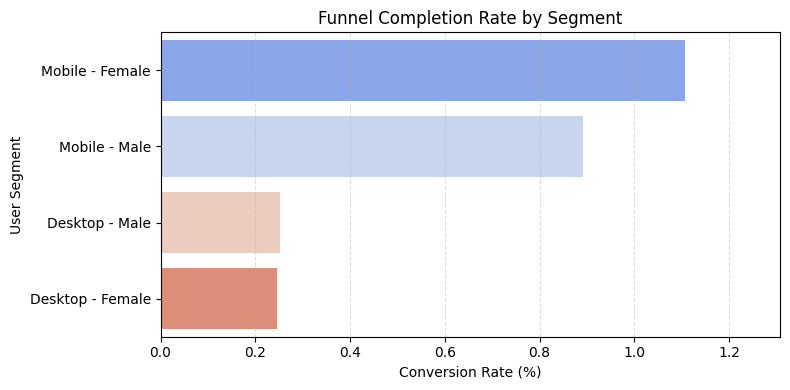

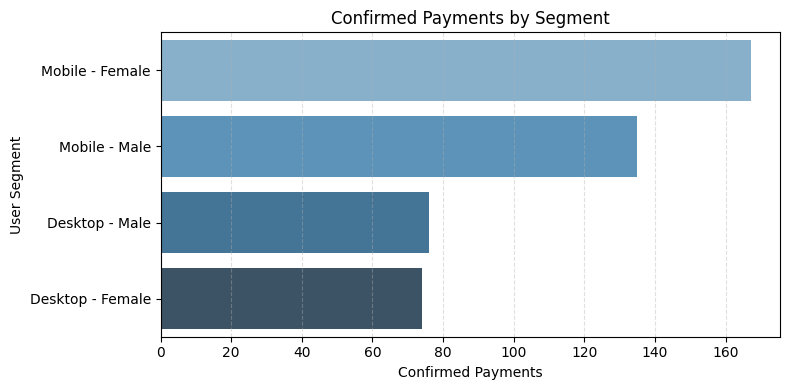

In [24]:
# 5. Who completed the full funnel?
# → Can we flag users who made it all the way through?
# → Create a filtered dataset of full converters for later segmentation, ltv modeling, and retention strategy
# Product pov: Understand this high-value segment to nurture lookalike audiences

import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Conversion Rate by Segment (sorted by rate)
plt.figure(figsize=(8, 4))
sns.barplot(
    data=rate_sorted,
    x='conversion_rate (%)',
    y='segment',
    hue='segment',  # Required for palette to apply
    palette='coolwarm',
    dodge=False,
    legend=False
)
plt.title('Funnel Completion Rate by Segment')
plt.xlabel('Conversion Rate (%)')
plt.ylabel('User Segment')
plt.xlim(0, rate_sorted['conversion_rate (%)'].max() + 0.2)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 2: Confirmed Payments by Segment (sorted by volume)
plt.figure(figsize=(8, 4))
sns.barplot(
    data=volume_sorted,
    x='confirmed_payments',
    y='segment',
    hue='segment',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title('Confirmed Payments by Segment')
plt.xlabel('Confirmed Payments')
plt.ylabel('User Segment')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Desktop females have the highest conversion rate, but the overall volume is small — so they’re not currently a major driver of revenue
# This pattern may still hold value if we want to optimize that segment, but we shouldn’t over-prioritize it without validating opportunity size
# Product pov: Given low volume, focus on improving mobile for female users first, since that segment has both high volume and decent conversion

Conversion Rate by Search Page Behavior
Behavior Group  Users  Confirmed Payments  Conversion Rate to Payment (%)
Visited Search  45200                 452                             1.0
Skipped Search  45200                   0                             0.0


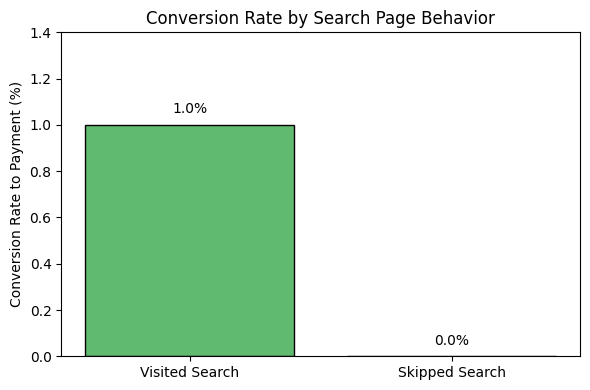

In [30]:
# 6. What might explain the drop offs?
# → Are there behavioral patterns, device mismatches, or usage patterns that predict drop off?
# → Identify patterns to explore e.g. users who skip the search page are 60% more likely to drop off at payment
# Product pov: Test nudging more users toward the search step earlier

# 📍 Conversion Rate by Search Page Behavior (Auto-Calculated)

import pandas as pd
import matplotlib.pyplot as plt

# Derive user segments
visited_search_df = funnel_df[funnel_df['visited_search'] == 1]
skipped_search_df = funnel_df[funnel_df['visited_search'] == 0]

# Calculate user volumes per funnel stage
visited_search = len(visited_search_df)
skipped_search = len(skipped_search_df)

confirmed_payment_visited = visited_search_df['confirmed_payment'].sum()
confirmed_payment_skipped = skipped_search_df['confirmed_payment'].sum()

# Compute conversion rates per funnel stage
conversion_rate_visited = (confirmed_payment_visited / visited_search) * 100
conversion_rate_skipped = (confirmed_payment_skipped / skipped_search) * 100

# Create summary table
summary_df = pd.DataFrame({
    'Behavior Group': ['Visited Search', 'Skipped Search'],
    'Users': [visited_search, skipped_search],
    'Confirmed Payments': [confirmed_payment_visited, confirmed_payment_skipped],
    'Conversion Rate to Payment (%)': [conversion_rate_visited, conversion_rate_skipped]
})

# Display table
print("Conversion Rate by Search Page Behavior")
print(summary_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(summary_df['Behavior Group'], summary_df['Conversion Rate to Payment (%)'],
              color=['#60ba6f', '#f4a261'], edgecolor='black')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05,
            f'{height:.1f}%', ha='center', fontsize=10)

ax.set_ylabel('Conversion Rate to Payment (%)')
ax.set_title('Conversion Rate by Search Page Behavior')
ax.set_ylim(0, max(summary_df['Conversion Rate to Payment (%)']) * 1.4)
plt.tight_layout()
plt.show()


# 100% of conversions came from users who visited the search page
# Users who skipped the search page represented 50% of the user base at this stage yet 0% converted
# Engagement with search is a necessary precursor to conversion in this funnel
# Search is an activation opportunity:
## → Nudge more users into it with tailored prompts pre-payment e.g. "find the best fit for you"
## → Test requiring search before payment access to verify causality
## → Boost inventives
### → Unlock exclusive filters or offers after searching
### → Use badges, trust icons, or interactive prompts that increase perceived value of search
## → Reinforce the value of search in messaging e.g. "most users find their match using search"

# Validation below

In [32]:
# Validate Conversion Rate by Search Page Behavior

# Filter dfs
visited_search_df = funnel_df[funnel_df['visited_search'] == 1]
skipped_search_df = funnel_df[funnel_df['visited_search'] == 0]

# Check user counts per funnel stage
visited_total = len(visited_search_df)
skipped_total = len(skipped_search_df)

visited_conversions = visited_search_df['confirmed_payment'].sum()
skipped_conversions = skipped_search_df['confirmed_payment'].sum()

# Display results
print("Verification Summary")
print(f"Visited Search – Users: {visited_total}, Confirmed Payments: {visited_conversions}")
print(f"Skipped Search – Users: {skipped_total}, Confirmed Payments: {skipped_conversions}")

# Check if skipped group truly has zero conversion rows
if skipped_conversions == 0:
    print("\nSkipped search users had zero conversions.")
    print("→ Consider inspecting skipped_search_df.head() for further insight.")
else:
    print("\nSome conversions occurred in skipped search group.")


# If we want to confirm why these users skipped search then we'd evaluate skipped_search_df.head()

Verification Summary
Visited Search – Users: 45200, Confirmed Payments: 452
Skipped Search – Users: 45200, Confirmed Payments: 0

Skipped search users had zero conversions.
→ Consider inspecting skipped_search_df.head() for further insight.


In [13]:
# 7. What could we do differently next sprint?
# (1) A/B test streamlined checkout flow, pre-filled payment, or trust signals e.g. “secure checkout” to reduce cart abandonment at payment page
# (2) Nudge users into search earlier (e.g. homepage module, intent detection) to drive more users to search
# (3) Test heatmaps, session replays, or survey to pinpoint UX or message gaps to diagnose male mobile friction